In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.colors as mcolors

from bin import utils
from sklearn.metrics import pairwise_distances

In [2]:
fdata = sc.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = sc.read_h5ad("./RNA/Multitime.guide.h5")

annotation = sc.read_h5ad("./RNA/Multitime.annotation.sort.h5")
annotation_guide = sc.read_h5ad("./RNA/Multitime.annotation.guide.h5")

In [3]:
fdata_ = fdata[fdata.obs["marker"] == '2-1'].copy()
cdata_ = cdata[cdata.obs["marker"] == '2-1'].copy()

annotation_ = annotation[annotation.obs["marker"] == '2-1'].copy()
annotation_guide_ = annotation_guide[annotation_guide.obs["marker"] == '2-1'].copy()

In [4]:
fdata_, cdata_ = utils.align_rna_guide_data(fdata_, cdata_)

cdata_ = utils.combine_guide_replicates(cdata_)
annotation_guide_ = utils.combine_guide_replicates(annotation_guide_)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


# Bin celltyping

In [5]:
def gene_mouse(fdata, str_):
    """
    Usage:
        Return mouse version of genes, check for absent genes
    """
    str_list = [t[0] + t[1:].lower() for t in str_]
    for str_ in str_list:
        if str_ not in fdata.var_names: print("Warning: " + str_ + " not in data variables!")
    return str_list

In [6]:
fibroblast_dict = {
    "myCAF": ["ACTA2", "POSTN", "INHBA", "MMP11", "ASPN", "PDGFRA", "LUM", "DCN"],
    "apCAF": ["HLA-DRA", "HLA-DRB1", "CD74"],
    "iCAF": ["IL6", "CXCL12", "CXCL14"],
    "Vascular CAF": ["NOTCH3", "COL18A1"]
}
for genes in fibroblast_dict:
    fibroblast_dict[genes] = gene_mouse(annotation_, fibroblast_dict[genes])

In [7]:
macro_dict = {
    'SPP1+IL1+ macro':['IL1B', 'CXCL8', 'SOD2', 'BCL2A1', 'CXCL2', 'CCL20', 'CXCL3', 'G0S2', 'C15orf48', 'PLAUR', 'EREG', 'IL1RN', 'TIMP1', 'BTG1', 'CCL3', 'PTGS2', 'NAMPT', 'SLC25A37', 'AQP9', 'SLC2A3', 'IL1A', 'TREM1', 'TNFAIP6', 'SERPINB9', 'INHBA', 'EHD1', 'S100A8', 'VCAN', 'NFKB1', 'GK', 'NLRP3', 'TNIP3', 'CCL4L2', 'IL6', 'S100A12', 'TNIP1', 'CD300E', 'CXCL1', 'FLT1', 'THAP2', 'AREG', 'SERPINB2', 'TRAF1', 'CXCL5', 'SLC7A5', 'IRAK2', 'ANGPTL4', 'F3', 'CDC42EP3', 'IL23A', 'DNAAF1', 'MAP4K4', 'ITGB8', 'PTX3', 'TRGC1', 'IL1R1', 'TNFSF14', 'SLCO4A1', 'CRADD', 'AK4', 'SLC7A11', 'HS3ST3B1', 'SLAMF1', 'MSC', 'MFSD2A', 'HILPDA', 'TNFSF15', 'TM4SF1', 'ADAM19', 'CSF3', 'LAMB3', 'NT5E', 'ZP3', 'ZNF697', 'GJB2', 'ACKR3', 'ECE1', 'HEY1', 'TMEM158', 'PRDM8', 'TRGC2', 'FAM124A', 'C6orf223', 'SYN1', 'EDN1', 'GGT5', 'TRGV5', 'NEU4', 'DGAT2', 'MET', 'CEMIP', 'S1PR3', 'ELOVL7', 'MN1', 'HAS1', 'ADGRG3', 'PTGES', 'C16orf74', 'MGAM'],
    'SPP1+TREM2+ macro':['SPP1', 'S100A6', 'LGALS1', 'S100A10', 'FABP5', 'CSTB', 'SPP1', 'FBP1', 'LSP1', 'CD9', 'CD52', 'GCHFR', 'S100A9', 'GLIPR2', 'APOC1', 'S100A8', 'CYP27A1', 'FN1', 'MGST1', 'SDC2', 'LPL', 'MATK', 'RETN', 'HSD3B7', 'CCL7', 'CHI3L1', 'TM4SF19', 'CST6', 'PPARG', 'HAMP', 'SEMA3C', 'DCSTAMP', 'SPOCD1', 'PCOLCE2', 'CHIT1', 'MMP7', 'AGRP', 'PHLDA3', 'JAKMIP2', 'ANKRD29', 'PRSS21', 'TPST1', 'HPGD', 'CES1', 'TIMP3', 'CYP19A1', 'HSD11B1', 'COL22A1', 'PAQR5', 'ADORA2B', 'ACOX2', 'SCG5', 'ALDH1A2', 'FABP4', 'CEBPE', 'SLC28A3', 'CRABP2', 'ASPHD1', 'DNASE2B', 'GPC4', 'FLRT2', 'CNIH3', 'GLDN', 'KCNJ15', 'GOLGA7B', 'MYOZ1', 'UCHL1', 'FBXO15', 'LEP', 'NLRP12', 'SLC22A16', 'WDR86', 'GAL', 'HES2', 'GPR27', 'TIMP4', 'EPHB1', 'PNCK', 'ELANE', 'GPD1', 'PHOSPHO1', 'SLCO4C1', 'PPM1J', 'KLHDC9'],
    'SPP1+MMP+ macro':['SPP1', 'C15orf48', 'MMP9', 'MMP12', 'SPP1', 'CXCL8', 'IL7R', 'BAG3', 'SLAMF9', 'SLC7A11', 'CXCL5', 'ENO2', 'SLC2A1', 'TNFRSF9', 'MMP1', 'MMP10', 'COL6A2', 'CYP27B1', 'CA12', 'SIGLEC15', 'TMEM45A', 'ITGB3', 'MUCL1', 'NEURL3', 'CP', 'C1QTNF1', 'AK8', 'CLLU1OS', 'CXCL6', 'FGF11', 'LAD1', 'TMEM132A', 'RNF207', 'GPR68', 'MYO1B', 'FJX1', 'CACNA1G', 'A4GALT', 'HTRA3', 'PPP1R1A', 'CD1A', 'COL27A1', 'ACTRT3', 'CRYAB', 'LAYN', 'NELL2', 'ADAMTS14', 'TGFBR3L', 'RTN4RL2', 'CGA', 'MT3', 'CCDC74A', 'RNF32', 'KISS1R'],
    'FOLR2+ macro':['C1QA', 'C1QB', 'MS4A6A', 'C1QC', 'SLC40A1', 'FOLR2', 'PDK4', 'MAF', 'MS4A7', 'GPR34', 'HLA-DQA1', 'SDC3', 'FGL2', 'CXCL12', 'CD163', 'CD302', 'LILRB5', 'SLCO2B1', 'CD5L', 'P2RY13', 'VCAM1', 'MPEG1', 'AXL', 'FRMD4B', 'LYVE1', 'WWP1', 'CETP', 'EPB41L2', 'LTC4S', 'METTL7A', 'DST', 'FRMD4A', 'SLC9A9', 'GATM', 'F13A1', 'IGF1', 'RGL1', 'TCF4', 'TMEM37', 'SESN1', 'NFIA', 'PDGFC', 'GPR155', 'CFP', 'ME1', 'RGS18', 'SCN1B', 'ATP6V0C', 'NDST3', 'CR1', 'MAN2B1', 'ITLN1', 'CLIC2', 'CD163L1', 'ADGRG6', 'FILIP1L', 'CD209', 'SESN3', 'RBP7', 'EBI3', 'ADORA3', 'GFRA2', 'MYO9A', 'KCNJ2', 'IGFBP4', 'SLC46A3', 'CYSLTR1', 'ITSN1', 'STON2', 'GCNT1', 'ALB', 'QPRT', 'EPS8', 'CPED1', 'IGSF21', 'NFATC2', 'RND3', 'TXNDC16', 'ITGAD', 'GIMAP5', 'EXT1', 'ITGA9', 'GIMAP8', 'CDH5', 'RAB3IL1', 'TIMD4', 'CNRIP1', 'HDAC9', 'SLC46A1', 'SIGLEC11', 'KCNAB1', 'HPGDS', 'SHE', 'PIK3R3', 'TBC1D4', 'SRGAP3', 'PROS1', 'FEZ1', 'TMEM26', 'CTSF'],
    'CXCL9+ macro': ['ISG15', 'IFITM3', 'CXCL10', 'GBP1', 'LY6E', 'ISG20', 'IFI6', 'TNFSF13B', 'LAP3', 'WARS', 'EPSTI1', 'TNFSF10', 'STAT1', 'MX1', 'IFIT3', 'VAMP5', 'TAP1', 'IFI35', 'GBP4', 'GBP5', 'IFI44L', 'PPA1', 'IFIT2', 'RSAD2', 'IRF7', 'MX2', 'IFIT1', 'APOBEC3A', 'CXCL11', 'ANKRD22', 'SAMD9L', 'OAS2', 'GCH1', 'IDO1', 'IFIH1', 'CXCL9', 'OAS3', 'HERC5', 'NT5C3A', 'SP110', 'CMPK2', 'OASL', 'FCN1', 'IFITM1', 'SLAMF7', 'HAPLN3', 'CCL8', 'LILRA5', 'USP18', 'DDX58', 'APOL3', 'ETV7', 'DEFB1', 'CD274', 'FPR2', 'IL27', 'LMNB1', 'SELL', 'GMPR', 'HELZ2', 'HESX1', 'NEXN', 'HSH2D', 'HERC6', 'LAMP3', 'CLEC4D', 'ADAM19', 'MEFV', 'ZBP1', 'EXOC3L1', 'CCR2', 'UBD', 'BCL2L14', 'CASP5', 'STAP1', 'BATF2', 'APOBEC3B', 'TGM1', 'FFAR2', 'GBP7', 'ATP10A', 'CCL19', 'STEAP4', 'NTNG2', 'IDO2', 'RUFY4', 'KCTD14', 'NPFFR1']
}
for genes in macro_dict:
    macro_dict[genes] = gene_mouse(annotation_, macro_dict[genes])

In [8]:
score_matrix = np.zeros((len(macro_dict.keys()), len(annotation_.obs_names)))
for idx, genes in enumerate(macro_dict):
    common_genes = np.array(macro_dict[genes])[np.isin(macro_dict[genes], annotation_.var_names)]
    score_matrix[idx, :] = np.array(annotation_[:, common_genes].X.mean(axis=1)).flatten()
name_map = pd.DataFrame(macro_dict.keys()).to_dict()[0]
type_df = pd.DataFrame(score_matrix.argmax(axis=0))[0].map(name_map)
type_df[score_matrix.sum(axis=0) == 0] = "Unknown Macro"
annotation_.obs["m_type"] = type_df.tolist()

In [9]:
score_matrix = np.zeros((len(fibroblast_dict.keys()), len(annotation_.obs_names)))
for idx, genes in enumerate(fibroblast_dict):
    common_genes = np.array(fibroblast_dict[genes])[np.isin(fibroblast_dict[genes], annotation_.var_names)]
    score_matrix[idx, :] = np.array(annotation_[:, common_genes].X.mean(axis=1)).flatten()
name_map = pd.DataFrame(fibroblast_dict.keys()).to_dict()[0]
type_df = pd.DataFrame(score_matrix.argmax(axis=0))[0].map(name_map)
type_df[score_matrix.sum(axis=0) == 0] = "Unknown Fibroblasts"
annotation_.obs["f_type"] = type_df.tolist()

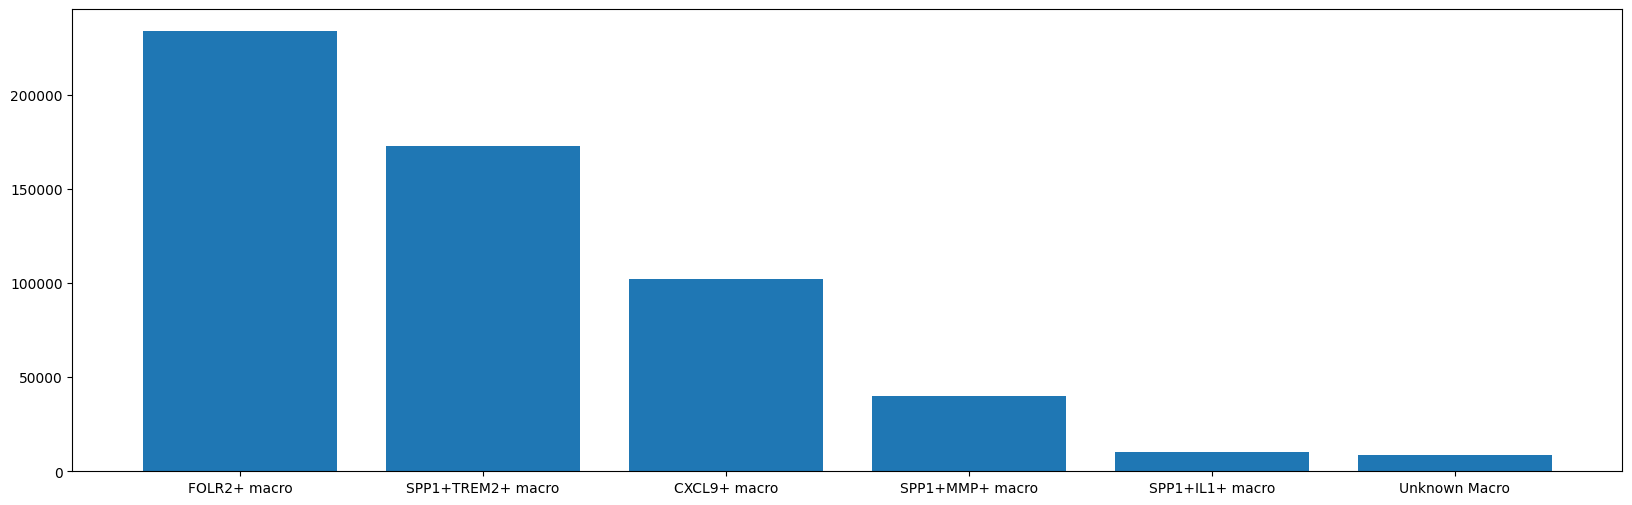

In [10]:
plt.figure(figsize=(20, 6))
c_df = annotation_.obs["m_type"].value_counts()
plt.bar(c_df.index, c_df)
plt.show()

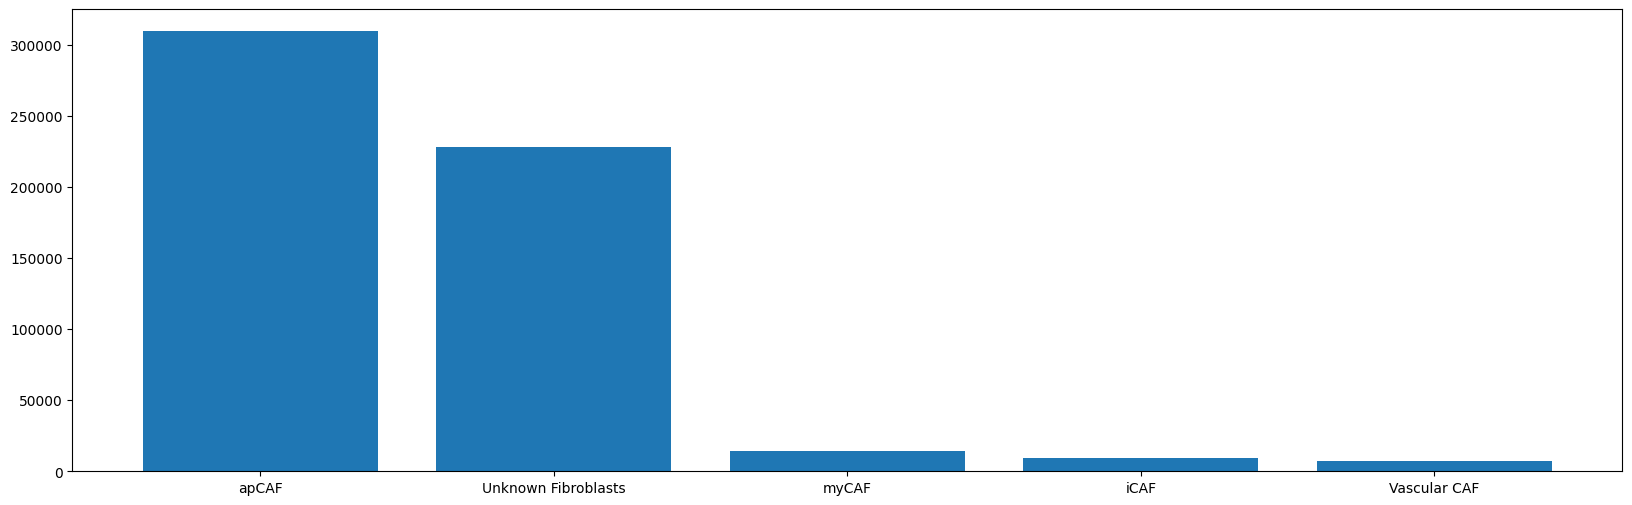

In [11]:
plt.figure(figsize=(20, 6))
c_df = annotation_.obs["f_type"].value_counts()
plt.bar(c_df.index, c_df)
plt.show()

In [12]:
mag_data = annotation_[annotation_.obs["annotations"] == "Malignant"].copy()
sc.pp.normalize_total(mag_data, target_sum=1e4)
sc.pp.log1p(mag_data)
sc.pp.pca(mag_data)

sc.pp.neighbors(mag_data)
sc.tl.umap(mag_data)
sc.tl.leiden(mag_data)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


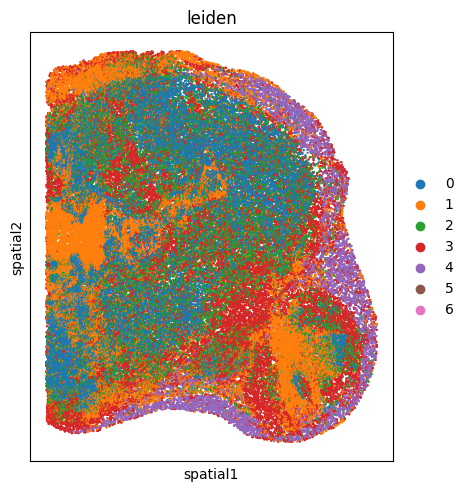

In [13]:
sq.pl.spatial_scatter(
    mag_data,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

In [14]:
sc.tl.rank_genes_groups(mag_data, method="t-test", groupby="leiden")

In [15]:
mag_data.uns["rank_genes_groups"]

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('H2-D1', 'Gphn', 'H2-K1', 'Myl6b', 'Acta1', 'Cdk8', 'Lyz2'),
            ('B2m', 'Camk1d', 'H2-D1', 'Ism2', 'Tnnc2', 'Il31ra', 'Ldha'),
            ('H2-K1', 'Il31ra', 'S100a6', 'Aicda', 'Tnnt3', 'Camk1d', 'Ctsb'),
            ...,
            ('Myl1', 'Cd74', 'Filip1l', 'Il31ra', 'Cd44', 'Efemp2', 'S100a6'),
            ('Filip1l', 'H2-K1', 'Jarid2', 'Cd44', 'H2-K1', 'Mybbp1a', 'AY036118'),
            ('Myh1', 'H2-D1', 'Cd44', 'Gphn', 'S100a6', 'Cenpa', 'H2-D1')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O')]),
 'scores': rec.array([(113.358864, 185.60033 ,  64.33191 ,    2.115231 , 247.91336 ,  16.354237,   11.24952 ),
            (111.139786, 181.92392 ,  61.525818,    1.9008341, 103.302574,  12.278609,   10.805863),
            ( 97.56336 , 181.8134  ,

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


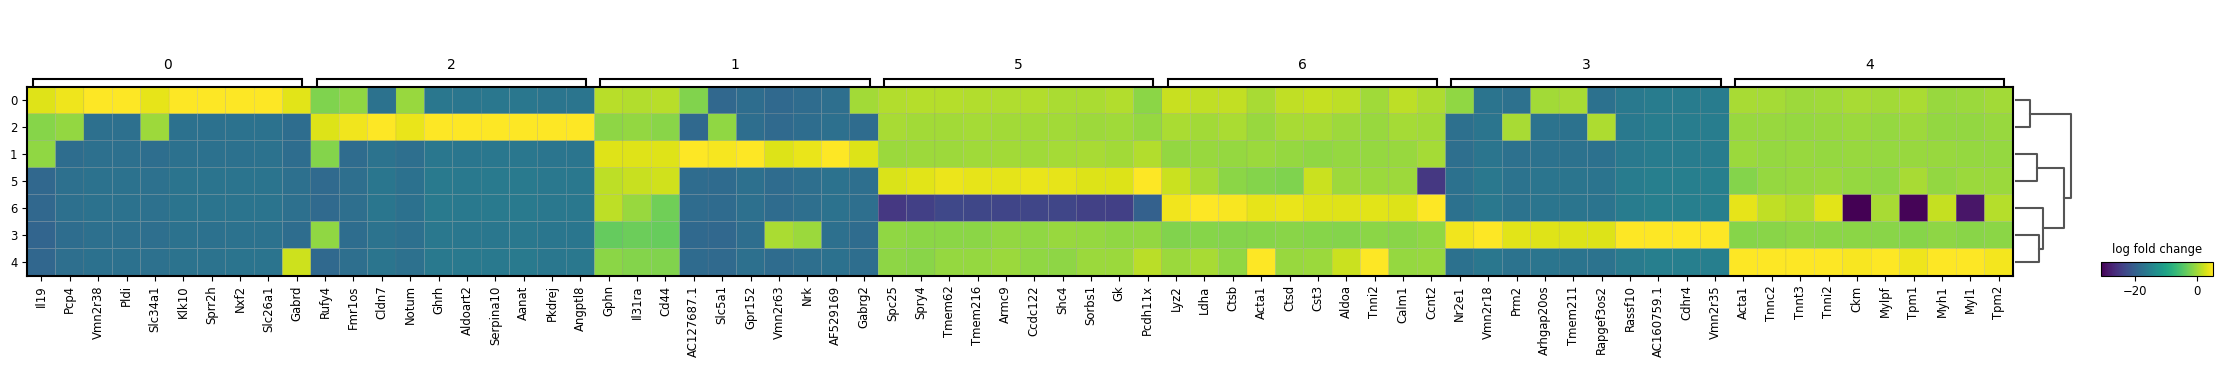

In [16]:
sc.pl.rank_genes_groups_matrixplot(mag_data, values_to_plot="logfoldchanges", min_logfoldchange=3, vmax=5)

# SPP1+ Tumor and SPP+ Macrophage

In [17]:
annotation_.obs["SPP_CD44"] = annotation_.obs["annotations"].tolist()
annotation_.obs["SPP_CD44"][(annotation_.obs["annotations"] == "Malignant")] = "_Other Malignant"
annotation_.obs["SPP_CD44"][(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten()] = "_SPP1+ Malignant"
annotation_.obs["SPP_CD44"][(annotation_.obs["annotations"] == "Macrophages")] = "_Other Macrophages"
annotation_.obs["SPP_CD44"][(annotation_.obs["annotations"] == "Macrophages") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten()] = "_SPP1+ Macrophages"
#annotation_.obs["SPP_CD44"][annotation_.obs["annotations"] == "Fibroblast"] = annotation_[annotation_.obs["annotations"] == "Fibroblast"].obs["f_type"].tolist()
annotation_.obs["SPP_CD44"][annotation_.obs["annotations"].str.endswith("T")] = "_Other T"
annotation_.obs["SPP_CD44"][annotation_.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()] = "_Regular T"
#annotation_.obs["SPP_CD44"][annotation_.obs["annotations"].str.endswith("T") & (annotation_[:, "Cd44"].X.toarray() > 0).flatten()] = "Cd44+ T"
annotation_.obs

/tmp/ipykernel_26903/67647100.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  annotation_.obs["SPP_CD44"][(annotation_.obs["annotations"] == "Malignant")] = "_Other Malignant"
/tmp/ipykernel_26903/67647100.py:2: SettingWithCopyWarning: 


,marker,annotations,cov,cluster,m_type,f_type,SPP_CD44
cov,,,,,,,
2-1_10010-10009,2-1,Macrophages,2-1_10010-10009,2.0,FOLR2+ macro,Unknown Fibroblasts,_Other Macrophages
2-1_10010-10029,2-1,Macrophages,2-1_10010-10029,2.0,FOLR2+ macro,Unknown Fibroblasts,_Other Macrophages
2-1_10010-10049,2-1,Macrophages,2-1_10010-10049,2.0,SPP1+TREM2+ macro,Unknown Fibroblasts,_Other Macrophages
2-1_10010-10069,2-1,Endothelial,2-1_10010-10069,2.0,FOLR2+ macro,apCAF,Endothelial
2-1_10010-10089,2-1,Macrophages,2-1_10010-10089,2.0,SPP1+TREM2+ macro,apCAF,_Other Macrophages
...,...,...,...,...,...,...,...
2-1_9989-9909,2-1,Fibroblast,2-1_9989-9909,2.0,SPP1+MMP+ macro,Unknown Fibroblasts,Fibroblast
2-1_9989-9929,2-1,Macrophages,2-1_9989-9929,2.0,FOLR2+ macro,Unknown Fibroblasts,_Other Macrophages
2-1_9989-9949,2-1,Others,2-1_9989-9949,2.0,FOLR2+ macro,Unknown Fibroblasts,Others


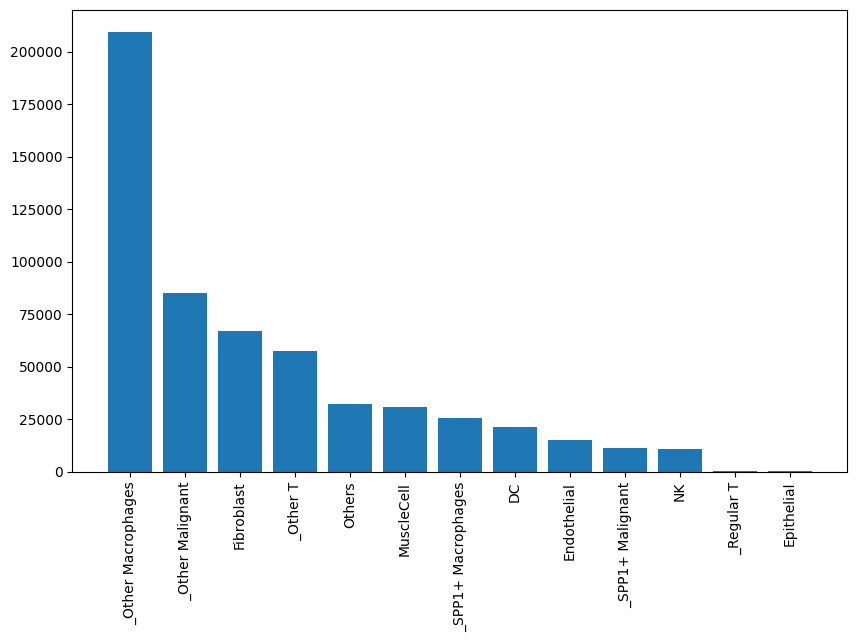

In [18]:
plt.figure(figsize=(10, 6))
c_df = annotation_.obs["SPP_CD44"].value_counts()
plt.bar(c_df.index, c_df)
plt.xticks(rotation=90)
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


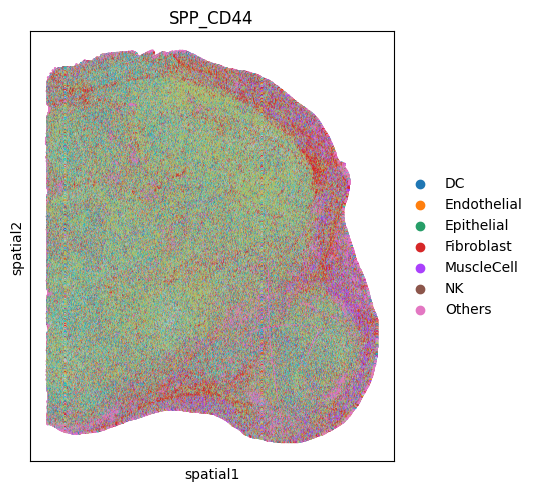

In [19]:
sq.pl.spatial_scatter(annotation_, color="SPP_CD44", shape=None, size=2, library_id="spatial")

In [20]:
field_name = "SPP_CD44"
annotation_.obs[field_name] = annotation_.obs[field_name].astype('category')
if "spatial_neighbors" not in annotation_.uns.keys():
    sq.gr.spatial_neighbors(annotation_, delaunay=True)
sq.gr.interaction_matrix(annotation_, field_name)
sq.gr.nhood_enrichment(annotation_, field_name)

  0%|          | 0/1000 [00:00<?, ?/s]

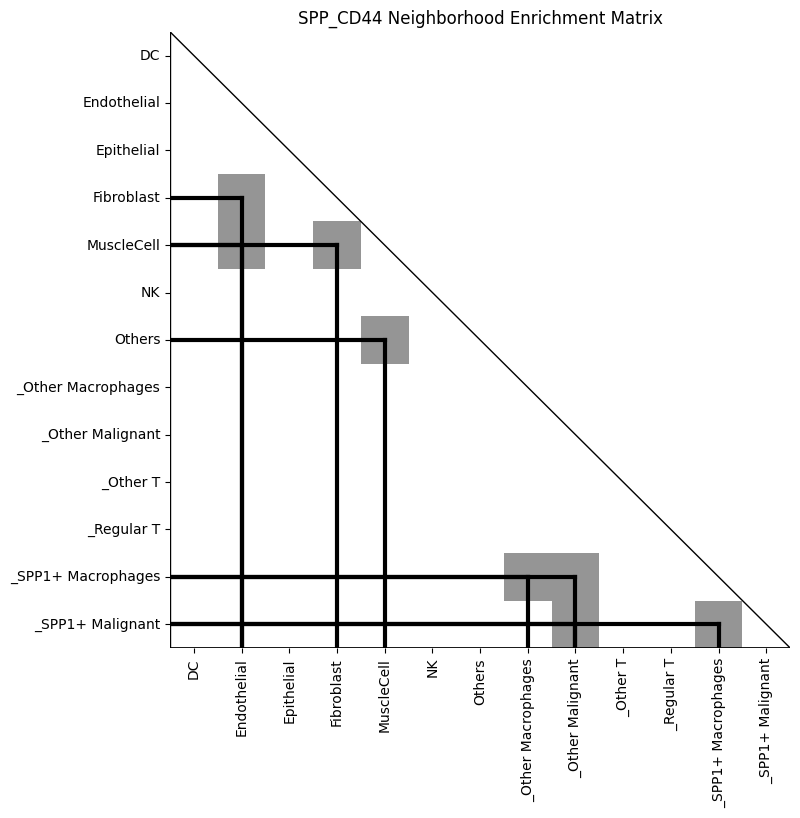

In [21]:
enrichment_matrix = annotation_.uns[f"{field_name}_nhood_enrichment"]['count']
zscores = annotation_.uns[f"{field_name}_nhood_enrichment"]['zscore']
relative_enrichment = enrichment_matrix > 0
significant_enrichment = (zscores > np.quantile(zscores, 0.85)) & relative_enrichment

binary_enrichment_matrix = np.where(significant_enrichment, 1, 0)
cluster_names = annotation_.obs[f"{field_name}"].cat.categories
binary_enrichment_df = pd.DataFrame(binary_enrichment_matrix, 
                                    index=cluster_names, 
                                    columns=cluster_names)

# Mask for the upper triangle
mask = np.triu(np.ones_like(binary_enrichment_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(binary_enrichment_df, mask=mask, annot=False, cmap='Greys', vmax=2, cbar=False, ax=ax)

s = len(cluster_names)
for i in range(s):
    for j in range(i):
        if binary_enrichment_df.iloc[i, j] == 1:
            # Draw vertical line from cell to x-axis
            ax.plot([j + 0.5, j + 0.5], [i+0.5, s], color='black', lw=3)
            # Draw horizontal line from cell to y-axis
            ax.plot([0, j+0.5], [i + 0.5, i + 0.5], color='black', lw=3)
ax.plot([s, 0], [s, 0], color='black', lw=1)
ax.plot([0, 0], [s, 0], color='black', lw=1)
ax.plot([0, s], [s, s], color='black', lw=2)

ax.set_title(f"{field_name} Neighborhood Enrichment Matrix", rotation=0)
plt.show()

In [22]:
inter_data = annotation_[annotation_.obs["SPP_CD44"].str.startswith("_")].copy()

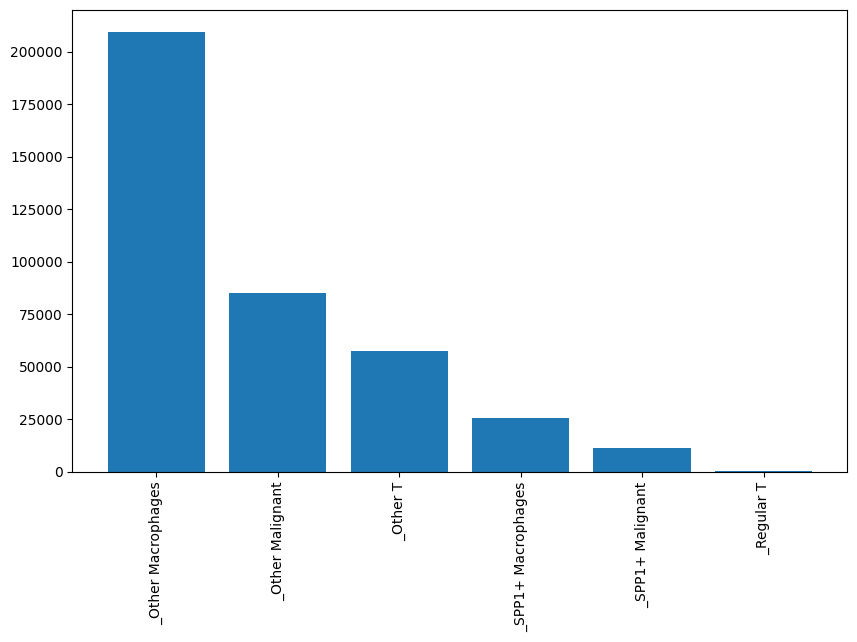

In [23]:
plt.figure(figsize=(10, 6))
c_df = inter_data.obs["SPP_CD44"].value_counts()
plt.bar(c_df.index, c_df)
plt.xticks(rotation=90)
plt.show()

In [24]:
field_name = "SPP_CD44"
inter_data.obs[field_name] = inter_data.obs[field_name].astype('category')
#if "spatial_neighbors" not in inter_data.uns.keys():
sq.gr.spatial_neighbors(inter_data, delaunay=True)
sq.gr.interaction_matrix(inter_data, field_name)
sq.gr.nhood_enrichment(inter_data, field_name)

  0%|          | 0/1000 [00:00<?, ?/s]

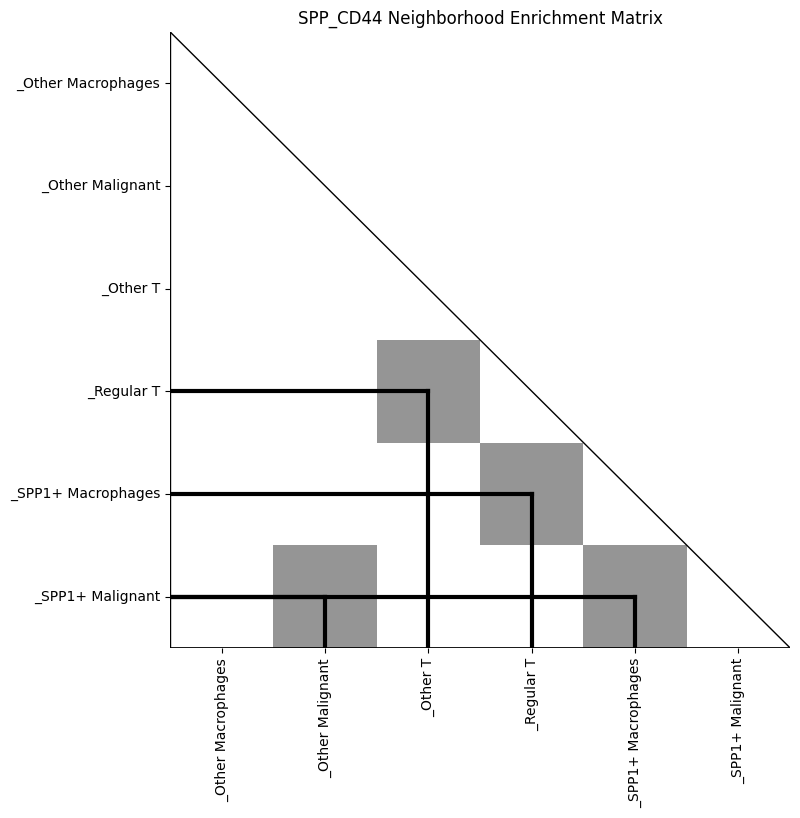

In [25]:
enrichment_matrix = inter_data.uns[f"{field_name}_nhood_enrichment"]['count']
zscores = inter_data.uns[f"{field_name}_nhood_enrichment"]['zscore']
relative_enrichment = enrichment_matrix > 0
significant_enrichment = (zscores > np.quantile(zscores, 0.6)) & relative_enrichment

binary_enrichment_matrix = np.where(significant_enrichment, 1, 0)
cluster_names = inter_data.obs[f"{field_name}"].cat.categories
binary_enrichment_df = pd.DataFrame(binary_enrichment_matrix, 
                                    index=cluster_names, 
                                    columns=cluster_names)

# Mask for the upper triangle
mask = np.triu(np.ones_like(binary_enrichment_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(binary_enrichment_df, mask=mask, annot=False, cmap='Greys', vmax=2, cbar=False, ax=ax)

s = len(cluster_names)
for i in range(s):
    for j in range(i):
        if binary_enrichment_df.iloc[i, j] == 1:
            # Draw vertical line from cell to x-axis
            ax.plot([j + 0.5, j + 0.5], [i+0.5, s], color='black', lw=3)
            # Draw horizontal line from cell to y-axis
            ax.plot([0, j+0.5], [i + 0.5, i + 0.5], color='black', lw=3)
ax.plot([s, 0], [s, 0], color='black', lw=1)
ax.plot([0, 0], [s, 0], color='black', lw=1)
ax.plot([0, s], [s, s], color='black', lw=2)

ax.set_title(f"{field_name} Neighborhood Enrichment Matrix", rotation=0)
plt.show()

# Autocorrelation

In [72]:
from scipy.spatial import distance_matrix
from libpysal.weights import DistanceBand
from esda.moran import Moran

In [62]:
sq.gr.spatial_neighbors(annotation_)

In [102]:
moran_dict = {
    "Moran's I": [],
    "p-value": []
}

In [103]:
spp1_macro_t = annotation_.copy()
spp1_macro_t.obs["I"] = 0
spp1_macro_t.obs["I"][(spp1_macro_t.obs["annotations"] == "Macrophages") & (spp1_macro_t[:, "Spp1"].X.toarray() > 0).flatten() | \
    spp1_macro_t.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()] = 1

/tmp/ipykernel_30161/333067902.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  spp1_macro_t.obs["I"][(spp1_macro_t.obs["annotations"] == "Macrophages") & (spp1_macro_t[:, "Spp1"].X.toarray() > 0).flatten() | \
/tmp/ipykernel_30161/333067

In [104]:
#dist_matrix = distance_matrix(spp1_macro_t.obsm['spatial'], spp1_macro_t.obsm['spatial'])
bandwidth = 45
w = DistanceBand(spp1_macro_t.obsm['spatial'], threshold=bandwidth)
feature = spp1_macro_t.obs['I']
moran = Moran(feature, w)
moran_dict['Moran\'s I'].append(moran.I)
moran_dict['p-value'].append(moran.p_sim)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  W.__init__(


('WARNING: ', 182583, ' is an island (no neighbors)')
('WARNING: ', 312001, ' is an island (no neighbors)')
('WARNING: ', 357201, ' is an island (no neighbors)')


In [105]:
other_macro_t = annotation_.copy()
other_macro_t.obs["I"] = 0
other_macro_t.obs["I"][(annotation_.obs["annotations"] == "Macrophages") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten() | \
    annotation_.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()] = 1

/tmp/ipykernel_30161/1862587834.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  other_macro_t.obs["I"][(annotation_.obs["annotations"] == "Macrophages") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten() | \
/tmp/ipykernel_30161/18625

In [106]:
#dist_matrix = distance_matrix(spp1_macro_t.obsm['spatial'], spp1_macro_t.obsm['spatial'])
bandwidth = 45
w = DistanceBand(other_macro_t.obsm['spatial'], threshold=bandwidth)
feature = other_macro_t.obs['I']
moran = Moran(feature, w)
moran_dict['Moran\'s I'].append(moran.I)
moran_dict['p-value'].append(moran.p_sim)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  W.__init__(


('WARNING: ', 182583, ' is an island (no neighbors)')
('WARNING: ', 312001, ' is an island (no neighbors)')
('WARNING: ', 357201, ' is an island (no neighbors)')


In [107]:
spp1_tumor_t = annotation_.copy()
spp1_tumor_t.obs["I"] = 0
spp1_tumor_t.obs["I"][(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten() | \
    annotation_.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()] = 1

/tmp/ipykernel_30161/312987799.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  spp1_tumor_t.obs["I"][(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten() | \
/tmp/ipykernel_30161/312987799.

In [108]:
#dist_matrix = distance_matrix(spp1_macro_t.obsm['spatial'], spp1_macro_t.obsm['spatial'])
bandwidth = 45
w = DistanceBand(spp1_tumor_t.obsm['spatial'], threshold=bandwidth)
feature = spp1_tumor_t.obs['I']
moran = Moran(feature, w)
moran_dict['Moran\'s I'].append(moran.I)
moran_dict['p-value'].append(moran.p_sim)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  W.__init__(


('WARNING: ', 182583, ' is an island (no neighbors)')
('WARNING: ', 312001, ' is an island (no neighbors)')
('WARNING: ', 357201, ' is an island (no neighbors)')


In [109]:
other_tumor_t = annotation_.copy()
other_tumor_t.obs["I"] = 0
other_tumor_t.obs["I"][(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten() | \
    annotation_.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()] = 1

/tmp/ipykernel_30161/4198715065.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  other_tumor_t.obs["I"][(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten() | \
/tmp/ipykernel_30161/4198715

In [110]:
#dist_matrix = distance_matrix(spp1_macro_t.obsm['spatial'], spp1_macro_t.obsm['spatial'])
bandwidth = 45
w = DistanceBand(other_tumor_t.obsm['spatial'], threshold=bandwidth)
feature = other_tumor_t.obs['I']
moran = Moran(feature, w)
moran_dict['Moran\'s I'].append(moran.I)
moran_dict['p-value'].append(moran.p_sim)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 182583, 312001, 357201.
  W.__init__(


('WARNING: ', 182583, ' is an island (no neighbors)')
('WARNING: ', 312001, ' is an island (no neighbors)')
('WARNING: ', 357201, ' is an island (no neighbors)')


In [111]:
moran_dict

{"Moran's I": [0.029705077431742482,
  0.04990267599120979,
  0.021372798660409673,
  0.021348301248251572],
 'p-value': [0.001, 0.001, 0.001, 0.001]}

# Spatial Distancing

In [14]:
regular_t = annotation_[annotation_.obs["annotations"].str.endswith("T") & (annotation_guide_[:, "sgNTC"].X > 0).flatten()]

In [29]:
spp1_macro = annotation_[(annotation_.obs["annotations"] == "Macrophages") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten()]
other_macro = annotation_[(annotation_.obs["annotations"] == "Macrophages") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten()]

spp1_tumor = annotation_[(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() > 0).flatten()]
other_tumor = annotation_[(annotation_.obs["annotations"] == "Malignant") & (annotation_[:, "Spp1"].X.toarray() == 0).flatten()]

In [31]:
distances = {}
distances["smacro_t"] = pairwise_distances(regular_t.obsm["spatial"], spp1_macro.obsm["spatial"])
distances["omacro_t"] = pairwise_distances(regular_t.obsm["spatial"], other_macro.obsm["spatial"])
distances["smag_t"] = pairwise_distances(regular_t.obsm["spatial"], spp1_tumor.obsm["spatial"])
distances["omag_t"] = pairwise_distances(regular_t.obsm["spatial"], other_tumor.obsm["spatial"])

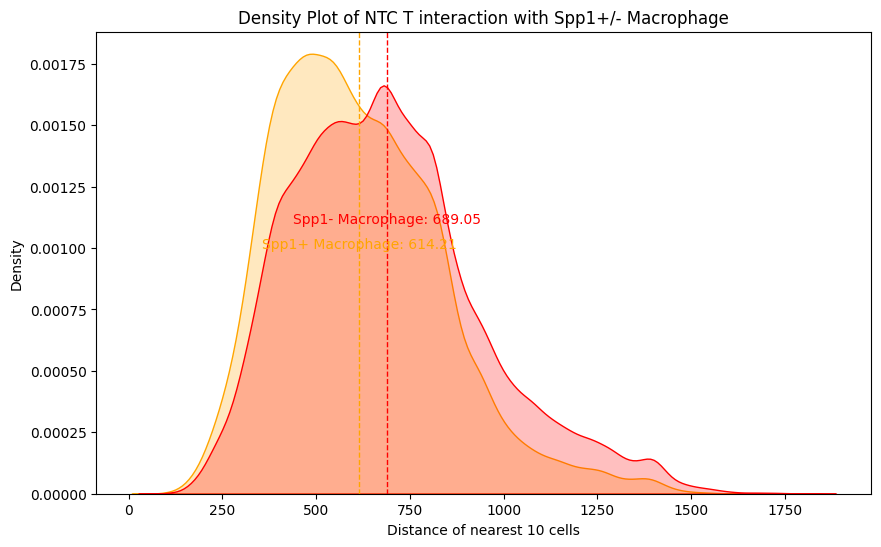

In [58]:
distance_dist = {}
for key in distances:
    distance_dist[key] = np.apply_along_axis(lambda x: np.mean(np.sort(x)[:5]), 0, distances[key])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

color = ["orange", "red", "green", "blue"]
names = ["Spp1+ Macrophage", "Spp1- Macrophage", "Spp1+ Malignant", "Spp1- Malignant"]
for idx, key in enumerate(distance_dist):
    if idx == 2 or idx == 3: continue
    sns.kdeplot(distance_dist[key], color=color[idx], fill=True, ax=ax)

    mean_value = np.mean(distance_dist[key])
    ax.axvline(mean_value, color=color[idx], linestyle='--', linewidth=1)
    ax.text(mean_value, idx / 10000 + 0.001, f'{names[idx]}: {mean_value:.2f}', color=color[idx], ha="center")

plt.title('Density Plot of NTC T interaction with Spp1+/- Macrophage')
plt.xlabel('Distance of nearest 10 cells')
plt.ylabel('Density')
plt.show()